In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cptac
import binarization_functions as bf
import gseapy as gp
from gseapy.plot import barplot, heatmap, dotplot
import json
import requests
import random
import deva

In [2]:
cptac.download(dataset='Ovarian')

ov = cptac.Ovarian()
proteomics = ov.get_proteomics()
transcriptomics = ov.get_transcriptomics()
clinical = ov.get_clinical()

## Step 2: Determine what attributes you would like to A/B test. 
For this analysis, we will iteratively go through the various columns in the clinical dataset, to determine if any of them have trends within them for protein enrichment.

In [3]:
columns_to_explore = ['Participant_History_Malignancy', 
                      'Sample_Tumor_Normal']

#Create a subsetted copy of the original Clinical DataFrame
annotations = pd.DataFrame(clinical[columns_to_explore].copy())

## Step 3: Perform Outlier Analysis
Using the Blacksheep-outliers package, deva, we will create two tables: one of all the significant up-regulated genes per patient (which we will call outliers), and one of the q-values for significantly enriched genes based on our binarized clinical attributes (which we will call qvalues).

In [4]:
outliers, qvalues = deva.run_outliers(proteomics.transpose(), 
                                      annotations,
                                      up_or_down='up',
                                      aggregate=False)

09/05/2019 15:34:56:WARNING:These samples were not found in outliers table: S001, S003, S004, S005, S008, S010, S014, S017, S018, S020, S021, S030, S032, S034, S036, S058, S072, S073, S075, S077, S081, S082, S083, S092, S099, S105, S109, S086, continuing without them. 
09/05/2019 15:34:57:WARNING:No rows tested for fisherFDR_Participant_History_Malignancy_No
09/05/2019 15:34:57:WARNING:These samples were not found in outliers table: S001, S003, S004, S005, S008, S010, S014, S017, S018, S020, S021, S030, S032, S034, S036, S058, S072, S073, S075, S077, S081, S082, S083, S086, S092, S099, S105, S109, continuing without them. 
09/05/2019 15:34:57:WARNING:No rows tested for fisherFDR_Sample_Tumor_Normal_Tumor


In [5]:
outliers_down, qvalues_down = deva.run_outliers(proteomics.transpose(), 
                                                annotations, 
                                                up_or_down='down', 
                                                aggregate=False)

09/05/2019 15:35:06:WARNING:These samples were not found in outliers table: S001, S003, S004, S005, S008, S010, S014, S017, S018, S020, S021, S030, S032, S034, S036, S058, S072, S073, S075, S077, S081, S082, S083, S092, S099, S105, S109, S086, continuing without them. 
09/05/2019 15:35:06:WARNING:No rows tested for fisherFDR_Participant_History_Malignancy_No
09/05/2019 15:35:07:WARNING:These samples were not found in outliers table: S001, S003, S004, S005, S008, S010, S014, S017, S018, S020, S021, S030, S032, S034, S036, S058, S072, S073, S075, S077, S081, S082, S083, S086, S092, S099, S105, S109, continuing without them. 
09/05/2019 15:35:07:WARNING:No rows tested for fisherFDR_Sample_Tumor_Normal_Tumor


In [6]:
length = int(len(outliers.df.columns) / 2)
temp_outliers = outliers.df.transpose()
only_outliers_up = temp_outliers[:length]
outliers_up_dict = {}
for i in range(length):
    key = proteomics.index[i]
    my_filter = only_outliers_up.iloc[i] == 1.0
    value = list(only_outliers_up.iloc[i][my_filter].index.get_level_values('Name'))
    outliers_up_dict[key] = value

In [7]:
length = int(len(outliers_down.df.columns) / 2)
temp_outliers_down = outliers_down.df.transpose()
only_outliers_down = temp_outliers_down[:length]
outliers_down_dict = {}
for i in range(length):
    key = proteomics.index[i]
    my_filter = only_outliers_down.iloc[i] == 1.0
    value = list(only_outliers_down.iloc[i][my_filter].index.get_level_values('Name'))
    outliers_down_dict[key] = value

## Step 4: Visualize these enrichments

First, we will determine which clinical attributes have significant enrichments, and save them to a list for both up-regulated outliers, and down-regulated outliers.

In [8]:
(qvalues.df['fisherFDR_Sample_Tumor_Normal_Normal']) < 0.05

Name     Database_ID 
A1BG     NP_570602        True
ABCA8    NP_001275914     True
ABCC1    NP_004987       False
ABHD5    NP_057090        True
ABI3BP   NP_056244        True
                         ...  
WISP2    NP_003872        True
ZBTB47   NP_660149        True
ZC2HC1A  NP_057094       False
ZNF512   NP_115810       False
ZNF787   NP_001002836     True
Name: fisherFDR_Sample_Tumor_Normal_Normal, Length: 671, dtype: bool

In [12]:
#Drop Columns with less than 4 significant up-regulated enrichments
sig_cols_up = []
results_up = qvalues.df.copy()
for col in qvalues.df.columns:
    sig_col = bf.significantEnrichments(qvalues.df, col)
    if sig_col is not None and len(sig_col) > 4:
        sig_cols_up.append(sig_col)
    else:
        results_up = qvalues.df.drop(col, axis=1)

In [10]:
sig_cols_up

[                      Participant_History_Malignancy_Yes, History of Other Cancer Greater Than One Year Ago_P_values
 Name    Database_ID                                                                                                 
 ABCC1   NP_004987                                              0.005885                                             
 ACP6    NP_057445                                              0.016543                                             
 ACY1    NP_001185824                                           0.021493                                             
 ADGRG2  NP_001073327                                           0.037442                                             
 AFG3L2  NP_006787                                              0.029014                                             
 ...                                                                 ...                                             
 UTP20   NP_055318                                      

In [13]:
results_up

,,"fisherFDR_Participant_History_Malignancy_Yes, History of Other Cancer Greater Than One Year Ago",fisherFDR_Sample_Tumor_Normal_Normal
Name,Database_ID,,
A1BG,NP_570602,NaN,1.530112e-06
ABCA8,NP_001275914,NaN,7.415921e-09
ABCC1,NP_004987,0.005885,NaN
ABHD5,NP_057090,NaN,2.160272e-03
ABI3BP,NP_056244,NaN,2.768223e-07
...,...,...,...
WISP2,NP_003872,NaN,9.958964e-06
ZBTB47,NP_660149,NaN,3.566993e-04
ZC2HC1A,NP_057094,0.014020,NaN


In [14]:
#Drop Columns with less than 4 significant down-regulated enrichments
sig_cols_down = []
results_down = qvalues_down.df.copy()
for col in qvalues_down.df.columns:
    sig_col = bf.significantEnrichments(qvalues_down.df, col)
    if sig_col is not None:
        sig_cols_down.append(sig_col)
    else:
        results_down = qvalues_down.df.drop(col, axis=1)

In [15]:
#Here we will link clinical attributes with significantly up-regulated genes
sig_genes_up = {}
for i, col in enumerate(sig_cols_up):
    list_of_genes = list(col.index.get_level_values('Name'))
    sig_genes_up[sig_cols_up[i].columns[0][:-9]] = list_of_genes   

In [16]:
#And then down-regulated genes
sig_genes_down = {}
for i, col in enumerate(sig_cols_down):
    list_of_genes = list(col.index.get_level_values('Name'))
    sig_genes_down[sig_cols_down[i].columns[0][:-9]] = list_of_genes

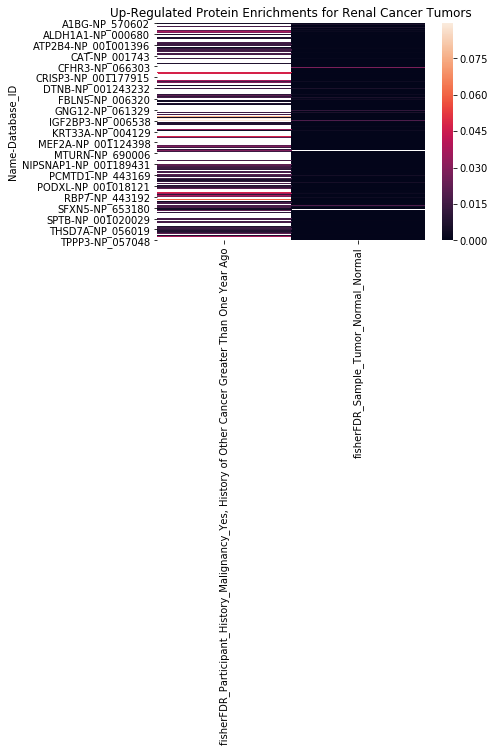

In [17]:
#Simple visualization
ax1 = plt.axes()
sns.heatmap(results_up, ax = ax1)
ax1.set_title('Up-Regulated Protein Enrichments for Renal Cancer Tumors')
plt.show()

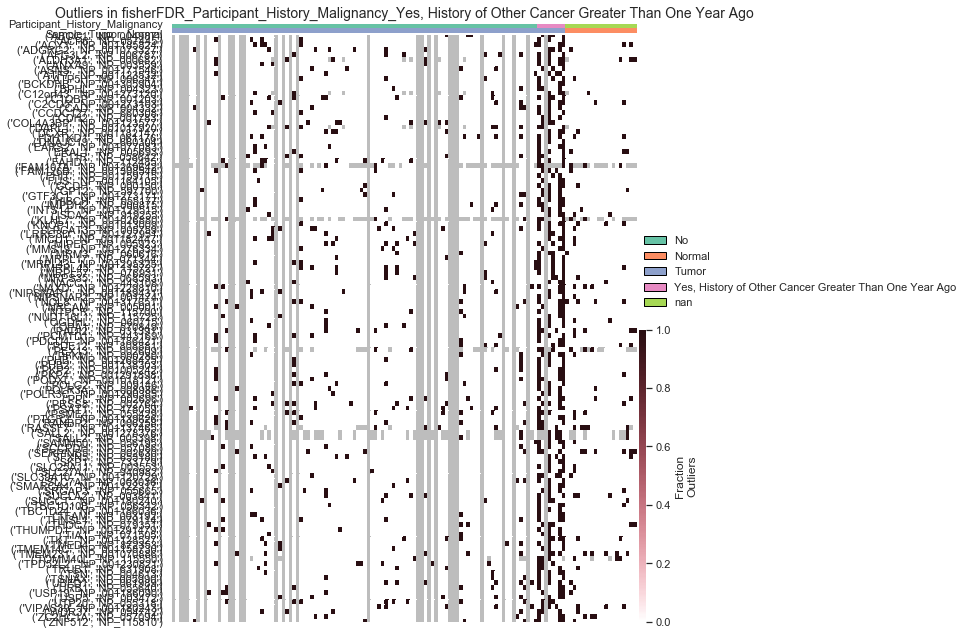

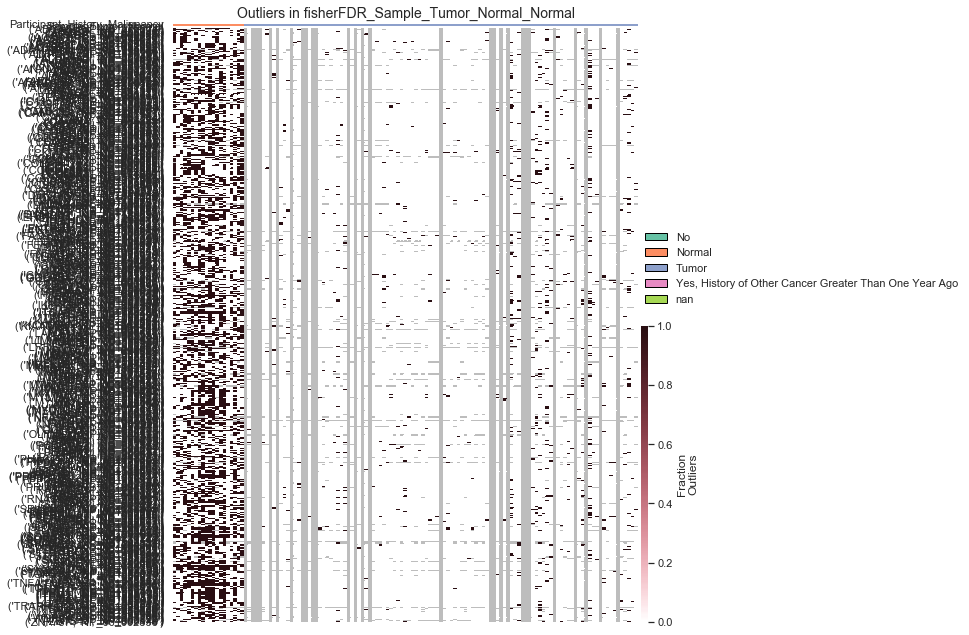

In [18]:
#Deva package visualization
for col in qvalues.df.columns:
    deva.plot_heatmap(
    annotations=annotations,
    qvals=qvalues.df,
    col_of_interest=col,
    vis_table=outliers.frac_table)
    
    plt.show()
    plt.close()

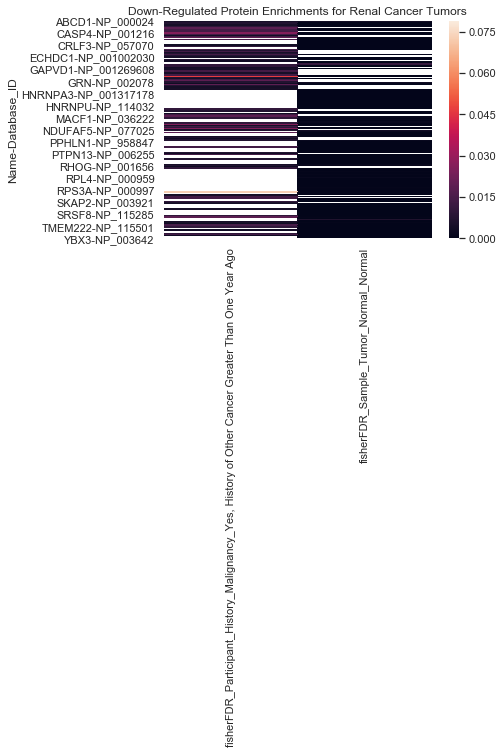

In [19]:
ax2 = plt.axes()
sns.heatmap(results_down, ax = ax2)
ax2.set_title('Down-Regulated Protein Enrichments for Renal Cancer Tumors')
plt.show()

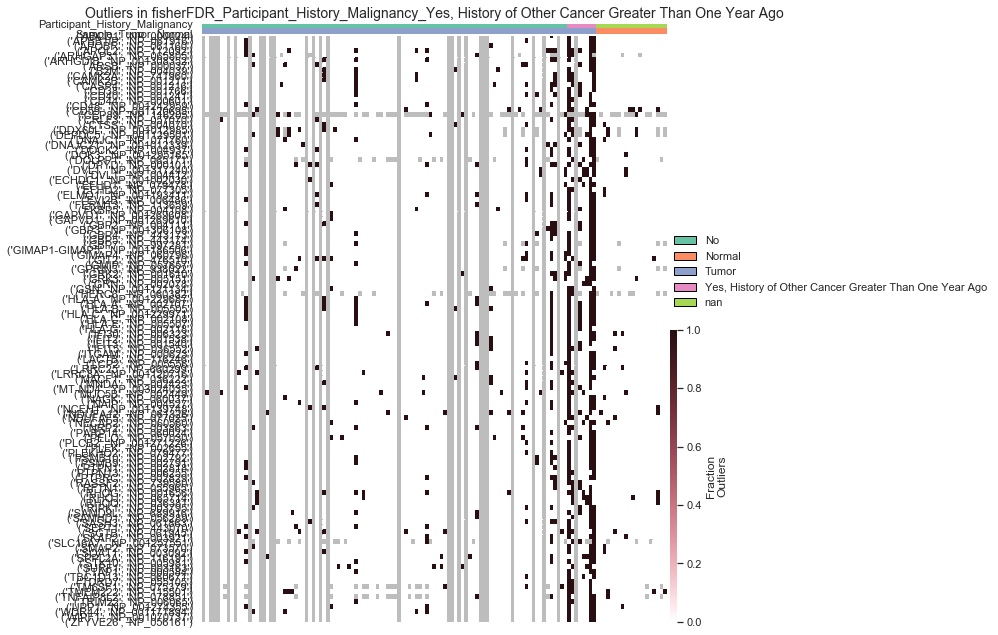

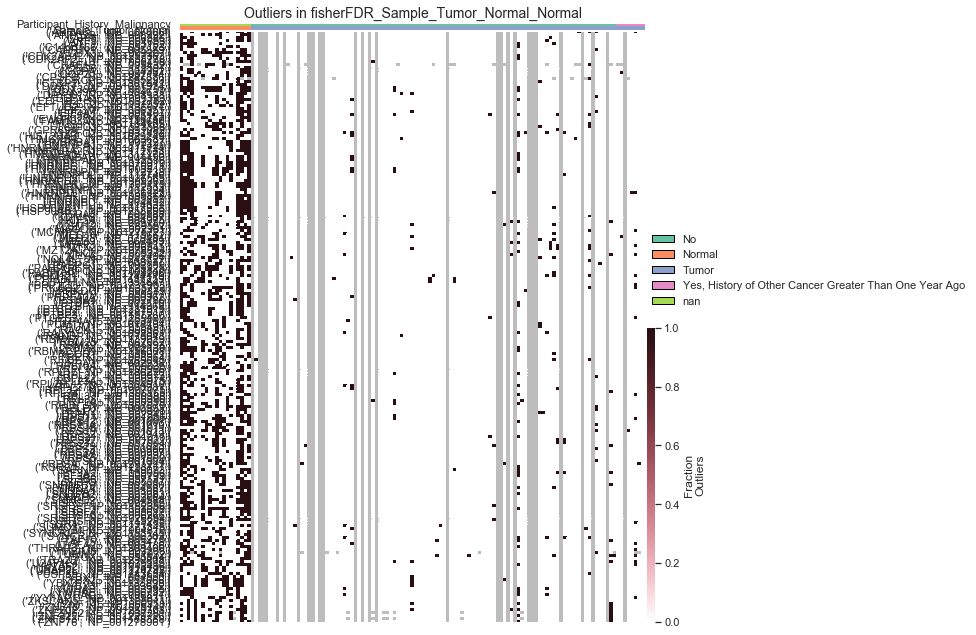

In [20]:
#Deva package visualization
for col in qvalues_down.df.columns:
    deva.plot_heatmap(
    annotations=annotations,
    qvals=qvalues_down.df,
    col_of_interest=col,
    vis_table=outliers_down.frac_table)
    
    plt.show()
    plt.close()

## Step 5: Perform Gene Set Enrichment Analysis

Part A: Up-regulated Genes

In [21]:
gsea_up = {}
for col in sig_cols_up:
    col_name = col.columns[0]
    col_name = "_".join(col_name.split(" "))
    print(col_name[:-9])
    gene_name_list = list(col.index.get_level_values('Name'))
    print('Gene List:', gene_name_list, '\n')
    enrichment = gp.enrichr(gene_list = gene_name_list, 
                            description=col_name, 
                            gene_sets='KEGG_2019_Human', 
                            outdir='test/renal')
    gsea_up[col_name] = enrichment
    barplot(enrichment.res2d, title=col_name, ofname=col_name)

Participant_History_Malignancy_Yes,_History_of_Other_Cancer_Greater_Than_One_Year_Ago
Gene List: ['ABCC1', 'ACP6', 'ACY1', 'ADGRG2', 'AFG3L2', 'ALDH3A1', 'ANXA9', 'ASNS', 'ATF7', 'ATP5H', 'BCKDHB', 'BPHL', 'C12orf43', 'C1QBP', 'C2CD5', 'CAD', 'CCDC127', 'CDH2', 'COL4A3BP', 'DAPL1', 'DCXR', 'DHTKD1', 'DNAJC19', 'EARS2', 'ERAL1', 'F11R', 'FAHD1', 'FAM107A', 'FAM126B', 'FHIT', 'FUS', 'GCDH', 'GPT2', 'GTF3C1', 'HIBCH', 'IMPDH2', 'INTS14', 'ISCA2', 'KLHL7', 'KNOP1', 'LPCAT3', 'LRRC8D', 'MICU1', 'MIPEP', 'MMS19', 'MRM3', 'MRPL17', 'MRPL43', 'MRPL45', 'MRPL57', 'MRPS35', 'NACC1', 'NAXD', 'NIPSNAP1', 'NIPSNAP2', 'NOL8', 'NRCAM', 'NTPCR', 'NUDT16L1', 'OGDHL', 'OPA1', 'PADI2', 'PCMTD1', 'PDCD4', 'PDE12', 'PEX13', 'PFKM', 'PHB', 'PHB2', 'PKP2', 'PKP4', 'PODXL', 'POLG2', 'POLR3A', 'POLR3C', 'PPL', 'PRSS8', 'PSAT1', 'PSME4', 'PTGR2', 'RANBP2', 'RASSF7', 'SALL2', 'SALL2', 'SAMM50', 'SCCPDH', 'SERPINB5', 'SFXN5', 'SKP1', 'SLC25A11', 'SLC27A1', 'SLC39A10', 'SLC7A1', 'SMARCA4', 'SRGAP3', 'SUCLA2', 'SUG

2019-09-05 15:39:39,029 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/05/2019 15:39:39:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Sample_Tumor_Normal_Normal
Gene List: ['A1BG', 'ABCA8', 'ABHD5', 'ABI3BP', 'ABL1', 'ACACA', 'ACADS', 'ACE', 'ACOT1', 'ACOT2', 'ACSL1', 'ACSL1', 'ACSL5', 'ACSL6', 'ACSS2', 'ACTA1', 'ACTA2', 'ACTBL2', 'ACTG2', 'ACTL6A', 'ADAMTSL4', 'ADCY6', 'ADGRA2', 'ADHFE1', 'ADIPOQ', 'AK1', 'ALB', 'ALDH1A1', 'ALDH1A2', 'ALOX15B', 'AMBP', 'AMPH', 'ANGPTL2', 'ANK1', 'ANK1', 'ANKAR', 'ANXA8', 'ANXA8L1', 'AOX1', 'APCS', 'APOB', 'APOC2', 'APOC4', 'APOD', 'APOE', 'APOF', 'APOL1', 'ARG1', 'ARHGAP10', 'ARHGAP6', 'ARPP19', 'ASPN', 'ATAD2B', 'ATG2A', 'ATL1', 'ATP2B4', 'AZGP1', 'B9D1', 'BAG2', 'BAG3', 'BCAP29', 'BCHE', 'BLVRB', 'BPGM', 'BPI', 'BRF1', 'BTD', 'C11orf96', 'C12orf75', 'C17orf58', 'C20orf27', 'C3', 'C4A', 'C4B', 'C8G', 'CA2', 'CAB39L', 'CAMK2G', 'CAMK2G', 'CAP2', 'CAT', 'CAV1', 'CAV1', 'CAV2', 'CAV3', 'CAVIN1', 'CAVIN2', 'CAVIN3', 'CBR3', 'CCDC50', 'CCDC50', 'CCDC88B', 'CD209', 'CD248', 'CD34', 'CD44', 'CD58', 'CD81', 'CD93', 'CD99L2', 'CDC42EP2', 'CDH13', 'CDH5', 'CDKN2C', 'CEACAM8', 'CEP135', 'CES2

Determine significant overlap for significantly up-regulated genes, first for patients with a history of cancer, adn then for patients with invasive carcinoma.

In [24]:
gsea_up

{'Participant_History_Malignancy_Yes,_History_of_Other_Cancer_Greater_Than_One_Year_Ago_P_values': <gseapy.enrichr.Enrichr at 0x1ff2479f048>,
 'Sample_Tumor_Normal_Normal_P_values': <gseapy.enrichr.Enrichr at 0x1ff0d881320>}

In [25]:
#Significant overlap for patients with a history of cancer
attribute = 'Sample_Tumor_Normal_Normal_P_values'
normal_tumor = gsea_up[attribute].res2d
sig_filter = normal_tumor['Adjusted P-value'] < 0.05
normal_tumor_sig = normal_tumor[sig_filter]
normal_tumor_sig

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2019_Human,Focal adhesion,41/199,4.345004e-26,1.338261e-23,0,0,8.341302,487.116884,LAMA5;TNXB;ROCK1;LAMA2;LAMA4;ITGA2B;ILK;LAMC1;...
1,KEGG_2019_Human,ECM-receptor interaction,21/82,5.264683e-16,8.107612e-14,0,0,10.368322,364.761109,LAMA5;TNXB;LAMA2;LAMB2;LAMA4;ITGA2B;LAMC1;COL1...
2,KEGG_2019_Human,Relaxin signaling pathway,23/130,1.144694e-13,1.175219e-11,0,0,7.162878,213.442786,GNAI3;GNG12;GNG11;ADCY6;GNAI1;GNAI2;COL1A1;GNA...
3,KEGG_2019_Human,Amoebiasis,18/96,1.990740e-11,1.532870e-09,0,0,7.591093,187.044001,LAMA5;LAMA2;ARG1;LAMB2;LAMA4;LAMC1;COL1A1;COL3...
4,KEGG_2019_Human,Pathways in cancer,42/530,3.155248e-11,1.943633e-09,0,0,3.208311,77.574937,NOTCH2;LAMA5;ROCK1;LAMA2;LAMA4;ITGA2B;LPAR1;GN...
...,...,...,...,...,...,...,...,...,...,...
65,KEGG_2019_Human,Salivary secretion,7/90,6.895742e-03,3.218013e-02,0,0,3.148898,15.671596,GUCY1A2;KCNMA1;ITPR1;ATP2B4;GNAS;VAMP2;ADCY6
66,KEGG_2019_Human,Arginine and proline metabolism,5/49,7.027035e-03,3.230338e-02,0,0,4.131207,20.482486,CKMT2;CKM;ARG1;MAOA;CKB
67,KEGG_2019_Human,Cocaine addiction,5/49,7.027035e-03,3.182833e-02,0,0,4.131207,20.482486,MAOA;GNAI3;GNAS;GNAI1;GNAI2
68,KEGG_2019_Human,Cholesterol metabolism,5/50,7.652968e-03,3.416107e-02,0,0,4.048583,19.727376,CETP;APOC2;LCAT;APOE;APOB


In [34]:
normal_tumor_sig[['Term', 'Overlap', 'Adjusted P-value']]

,Term,Overlap,Adjusted P-value
0,Focal adhesion,41/199,1.338261e-23
1,ECM-receptor interaction,21/82,8.107612e-14
2,Relaxin signaling pathway,23/130,1.175219e-11
3,Amoebiasis,18/96,1.532870e-09
4,Pathways in cancer,42/530,1.943633e-09
...,...,...,...
65,Salivary secretion,7/90,3.218013e-02
66,Arginine and proline metabolism,5/49,3.230338e-02
67,Cocaine addiction,5/49,3.182833e-02
68,Cholesterol metabolism,5/50,3.416107e-02


In [38]:
list(normal_tumor_sig['Term'])

['Focal adhesion',
 'ECM-receptor interaction',
 'Relaxin signaling pathway',
 'Amoebiasis',
 'Pathways in cancer',
 'Protein digestion and absorption',
 'PI3K-Akt signaling pathway',
 'Apelin signaling pathway',
 'Platelet activation',
 'Circadian entrainment',
 'Regulation of actin cytoskeleton',
 'Vascular smooth muscle contraction',
 'Dilated cardiomyopathy (DCM)',
 'Hypertrophic cardiomyopathy (HCM)',
 'Dopaminergic synapse',
 'Serotonergic synapse',
 'Glutamatergic synapse',
 'cGMP-PKG signaling pathway',
 'Oxytocin signaling pathway',
 'Morphine addiction',
 'Small cell lung cancer',
 'Proteoglycans in cancer',
 'Cholinergic synapse',
 'Human papillomavirus infection',
 'GABAergic synapse',
 'Human cytomegalovirus infection',
 'Complement and coagulation cascades',
 'Retrograde endocannabinoid signaling',
 'Toxoplasmosis',
 'Fatty acid biosynthesis',
 'Adrenergic signaling in cardiomyocytes',
 'Leukocyte transendothelial migration',
 'Fluid shear stress and atherosclerosis',
 'A

In [26]:
genes = normal_tumor_sig['Genes']
terms = normal_tumor_sig['Term']
normal_tumor_dict = {}
for i, gene in enumerate(genes):
    normal_tumor_dict[terms[i]] = gene.split(';')
normal_tumor_dict

{'AGE-RAGE signaling pathway in diabetic complications': ['COL1A1',
  'MAPK8',
  'COL3A1',
  'COL1A2',
  'COL4A2',
  'COL4A1',
  'COL4A3',
  'COL4A6',
  'COL4A5'],
 'Adipocytokine signaling pathway': ['MAPK8',
  'ACSL1',
  'NPY',
  'ADIPOQ',
  'ACSL6',
  'ACSL5',
  'IKBKG'],
 'Adrenergic signaling in cardiomyocytes': ['TPM4',
  'TPM3',
  'TPM2',
  'TPM1',
  'GNAI3',
  'ATP2B4',
  'SLC8A1',
  'ADCY6',
  'GNAI1',
  'GNAI2',
  'PPP2R5E',
  'GNAS',
  'CAMK2G',
  'MYH6'],
 'Alcoholism': ['HDAC4',
  'MAOA',
  'GNAI3',
  'GNG12',
  'GNG11',
  'GNAI1',
  'GNAI2',
  'GNAO1',
  'GNG2',
  'GNB2',
  'NPY',
  'GNB1',
  'GNAS',
  'GNB4',
  'GNB3'],
 'Amoebiasis': ['LAMA5',
  'LAMA2',
  'ARG1',
  'LAMB2',
  'LAMA4',
  'LAMC1',
  'COL1A1',
  'COL3A1',
  'C8G',
  'COL1A2',
  'COL4A2',
  'COL4A1',
  'COL4A3',
  'COL4A6',
  'GNAS',
  'COL4A5',
  'CTSG',
  'VCL'],
 'Apelin signaling pathway': ['MEF2A',
  'HDAC4',
  'ITPR1',
  'GNAI3',
  'GNG12',
  'GNG11',
  'SLC8A1',
  'ADCY6',
  'GNAI1',
  'MYLK',
  'GN

## Step 6: Connect Findings with Druggable Genome Interactive Database (DGIdb)

In [27]:
normal_tumor_requests = {}
normal_tumor_requests_parsed = {}
for term, gene_list in normal_tumor_dict.items():
    normal_tumor_requests[term] = bf.dgidb_get_request(gene_list)
    normal_tumor_requests_parsed[term] = bf.dgidb_json_parse(normal_tumor_requests[term], genes=True)

print(json.dumps(normal_tumor_requests_parsed, indent=4))

{
    "Focal adhesion": {
        "LAMA5": {
            "OCRIPLASMIN": [],
            "ANTAZOLINE HYDROCHLORIDE": []
        },
        "ROCK1": {
            "HYDROXYFASUDIL": [
                "inhibitor"
            ],
            "METHYL NONYL KETONE": [
                "inhibitor"
            ],
            "FASUDIL": [
                "inhibitor"
            ],
            "GSK-269962A": [
                "inhibitor"
            ],
            "TOLAZOLINE": [
                "inhibitor"
            ],
            "CHEMBL2005186": [
                "inhibitor"
            ],
            "SAR-407899 (CHEMBL1667969)": [
                "inhibitor"
            ],
            "VEROSUDIL": [
                "inhibitor"
            ],
            "Y-27632": [
                "inhibitor"
            ],
            "Y-39983": [
                "inhibitor"
            ],
            "AMA0076": [
                "inhibitor"
            ],
            "CHEMBL406821": [
                "inh

}


## Step 7: Personalized Medicine

In [28]:
# To perform a request specifically for inhibitors, you may opt to use a loop
# While this option is slower than the map, it is more specific, and may be worth
# waiting a few more seconds to reduce manual sifting through interaction types
inhibitors = {}
for attribute, genes in sig_genes_up.items():
    inhibitors[attribute] = bf.dgidb_get_request(genes, interaction_types=['inhibitor'])

In [29]:
print('UP-REGULATED INHIBITOR REQUEST:\n')
inhibitors_parsed = {}
for attribute, request in inhibitors.items():
    inhibitors_parsed[attribute] = bf.dgidb_json_parse(request, genes=True)
print(json.dumps(inhibitors_parsed, indent=4))

UP-REGULATED INHIBITOR REQUEST:

{
    "Participant_History_Malignancy_Yes, History of Other Cancer Greater Than One Year Ago": {
        "ABCC1": {
            "SULFINPYRAZONE": [
                "modulator",
                "inhibitor"
            ]
        },
        "IMPDH2": {
            "MYCOPHENOLATE MOFETIL HYDROCHLORIDE": [
                "inhibitor"
            ],
            "THIOGUANINE": [
                "inhibitor"
            ],
            "RIBAVIRIN": [
                "inhibitor"
            ],
            "MYCOPHENOLIC ACID": [
                "inhibitor"
            ],
            "MYCOPHENOLATE MOFETIL": [
                "inhibitor"
            ]
        },
        "PSME4": {
            "CARFILZOMIB": [
                "inhibitor"
            ],
            "BORTEZOMIB": [
                "inhibitor"
            ]
        },
        "PTGR2": {
            "INDOMETHACIN": [
                "inhibitor"
            ]
        },
        "SLC27A1": {
            "N

}


In [31]:
random.seed(8)
patients_to_check_up = []
for i in range(3):
    index = random.randrange(0, len(only_outliers_up))
    while clinical.index[index] not in outliers_up_dict.keys() and index < len(outliers_up_dict.keys()):
        index += 1
    patients_to_check_up.append(clinical.index[index])

In [33]:
personalized_up = {}
for patient in patients_to_check_up:
    patients_up_dict = bf.dgidb_get_request(outliers_up_dict[patient], 
                                            interaction_types = ['inhibitor'])
    parsed = bf.dgidb_json_parse(patients_up_dict, genes=True)
    personalized_up[patient] = parsed
print(json.dumps(personalized_up, indent = 4))

{
    "S031": {
        "BRD2": {
            "CHEMBL1828986": [
                "inhibitor"
            ],
            "LY-294002": [
                "inhibitor"
            ],
            "CHEMBL1738777": [
                "inhibitor"
            ],
            "CHEMBL2153434": [
                "inhibitor"
            ],
            "CHEMBL2017291": [
                "inhibitor"
            ],
            "CHEMBL1232461": [
                "inhibitor"
            ]
        },
        "BRD4": {
            "CHEMBL2431090": [
                "inhibitor"
            ],
            "CHEMBL3220860": [
                "inhibitor"
            ],
            "CHEMBL1232461": [
                "inhibitor"
            ],
            "CHLORMEZANONE": [
                "inhibitor"
            ],
            "FEDRATINIB": [
                "inhibitor"
            ],
            "CHEMBL1828986": [
                "inhibitor"
            ],
            "BI-2536": [
                "inhibitor"
    

}
